In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math


In [2]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

## get data 

In [240]:
ger_train_path = "/home/adam/play/translate_data/train.de"
eng_train_path = "/home/adam/play/translate_data/train.en"

ger_train_raw = open(ger_train_path, "r").readlines()
eng_train_raw = open(eng_train_path, "r").readlines()

# just to help my poor laptop
ger_train_raw = ger_train_raw[:10000]
eng_train_raw = eng_train_raw[:10000]

In [241]:
print(len(ger_train))
print(len(eng_train))

10000
10000


In [242]:
### tokenize 
tokenizer = Tokenizer(BPE())

tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]) # do i need to account for the weird #AT things??
tokenizer.train(files=[ger_train_path, eng_train_path,], trainer=trainer)
tokenizer.enable_padding()
# tokenizer.train_from_iterator(iter(ger_train + eng_train), trainer=trainer)


In [243]:
ger_train = tokenizer.encode_batch(ger_train_raw)
eng_train = tokenizer.encode_batch(eng_train_raw)

In [244]:
ger_train = torch.tensor([t.ids for t in ger_train])
eng_train = torch.tensor([t.ids for t in eng_train])

In [245]:
ger_train.shape

torch.Size([10000, 258])

## define model

In [239]:
def create_mask(src, targ, pad_token):
    # NOTE: not fully confident in the unsqueeze - i think we get the extra-dimension so the masked_fill can broadcast it 
    # we want to broadcast for the padding mask because it's the same on both axes (unlike with the causal mask) 
    src_pad_mask = (src != pad_token).unsqueeze(1) # (B, 1, context_size)
    targ_pad_mask = (targ != pad_token).unsqueeze(1)
    full_mask = torch.ones((targ.shape[1], targ.shape[1])).type(torch.int)
    causal_atten_mask = torch.tril(full_mask) # (context_size, context_size)

    return src_pad_mask, targ_pad_mask & causal_atten_mask

def calculate_loss(logits, labels):
    B, T, V = logits.shape # (batch, context_size, vocab_size)
    # cross entropy expects list of indices and logits requiring reshape
    return F.cross_entropy(logits.reshape(B * T, V), labels.reshape(B * T), ignore_index=PAD_IDX)

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, n_embed, dropout, store_kv=False):
        super().__init__()
        self.n_embed = n_embed
        self.n_heads = n_heads
        assert(n_embed % n_heads == 0) # check dims work
        self.head_size = n_embed // n_heads
        self.dropout = dropout
        self.store_kv = store_kv

        self.wk = nn.Linear(n_embed, n_embed, bias=False)
        self.wq = nn.Linear(n_embed, n_embed, bias=False)
        self.wv = nn.Linear(n_embed, n_embed, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(n_embed, n_embed)

    def forward(self, k_in, q_in, v_in, mask):
        B, T, C = k_in.shape # (batch, context_size, n_embed)

        # create k
        # NOTE: make sure the maths works here
        k = self.wk(k_in) # (B, context_size, n_embed) @ (n_embed, n_embed) ---> (B, context_size, n_embed)
        # we store kv in the final encoder layer so that the decoders can use it
        if self.store_kv:
            self.stored_k = k
        # split per head
        k = k.view(B, T, self.n_heads, self.head_size)  # (B, context_size, n_embed) --> (B, context_size, n_heads, head_size)
        # switch context size and n_heads dim so we can batch matmul over B and n_heads
        k = k.transpose(1,2) # (B, context_size, n_heads, head_size) --> (B, n_heads, context_size, head_size)
        
        # create q 
        q = self.wq(q_in)
        q = q.view(q.shape[0], q.shape[1], self.n_heads, self.head_size) # q can be a different shape to k and v so need to use its own shape
        q = q.transpose(1,2)

        # create v 
        v = self.wv(v_in)
        if self.store_kv:
            self.stored_v = v
        v = v.view(B, T, self.n_heads, self.head_size)
        v = v.transpose(1, 2)

        attn = q @ k.transpose(-2, -1) # (B, n_heads, context_size, head_size) @ (B, n_heads, head_size, context_size) --> (B, n_heads, context_size, context_size)
        attn = attn / (self.n_embed ** 0.5) # divide by squareroot of n_embed to decrease magnitude
        
        # if this is a masked attention layer (causal?) mask out all tokens before the cur pos, otherwise just mask out padding 
        attn = attn.masked_fill(mask.unsqueeze(1) == 0, float("-inf")) # TODO: check that the dimensions here work
        attn = self.dropout(F.softmax(attn, dim=-1))
        
        # generate the v matrix and use the attn matrix to pluck out relevant info on a per head basis
        out = attn @ v # (B, n_heads, context_size, context_size) @ (B, n_heads, context_size, head_size) --> (B, n_heads, context_size, head_size)
        # remove per-head dimension and use final linear projection
        out = out.view(out.shape[0], -1, self.n_embed) # (B, n_heads, context_size, head_size) --> (B, context_size, n_embed)
        return self.proj(out)

class FeedForward(nn.Module):
    def __init__(self, n_embed, dropout):
        super().__init__()
        self.ffw = nn.Sequential(
            nn.Linear(n_embed, 4* n_embed),
            nn.ReLU(),
            nn.Linear(4*n_embed, n_embed),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.ffw(x) # (B, context_size, n_embed) @ (n_embed, 4*n_embed) @ (4*n_embed, n_embed) --> (B, context_size, n_embed)

class EncoderBlock(nn.Module):
    def __init__(self, n_heads, n_embed, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(n_heads, n_embed, dropout, True)
        self.ffw = FeedForward(n_embed, dropout)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, inputs):
        x, mask = inputs
        out = self.attention(x, x, x, mask)
        out = self.ln1(out) + x
        out = self.ffw(out)
        out = self.ln2(out) + x
        return (out, mask)

class DecoderBlock(nn.Module):
    def __init__(self, n_heads, n_embed, dropout):
        super().__init__()
        self.masked_attention = MultiHeadAttention(n_heads, n_embed, dropout)
        self.attention = MultiHeadAttention(n_heads, n_embed, dropout)
        self.ffw = FeedForward(n_embed, dropout)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
        self.ln3 = nn.LayerNorm(n_embed)

    def forward(self, inputs):
        # unpack inputs
        x, k_in, v_in, src_mask, targ_mask = inputs
        out = self.masked_attention(x, x, x, targ_mask)
        out = self.ln1(out) + x
        out = self.attention(k_in, out, v_in, src_mask)
        out = self.ln2(out) + x
        out = self.ffw(out)
        out = self.ln3(out) + x
        return (x, k_in, v_in, src_mask, targ_mask)

class PositionalEmbedding(nn.Module):
    def __init__(self, n_embed, context_size):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        posem = torch.zeros((context_size+1, n_embed))
        for pos in range(context_size+1):
            for i in range(n_embed, 2):
                posem[pos, i] = math.sin(pos/(10000**(2*i/n_embed)))
                posem[pos, i+1] = math.cos(pos/(10000**(2*(i+1)/n_embed)))
        posem.unsqueeze(0)
        self.register_buffer("posem", posem)

    def forward(self, x):
        return x + self.posem[torch.arange(x.shape[1]),:]

class Generator(nn.Module):
    def __init__(self, n_embed, output_vocab_size):
        super().__init__()
        self.proj = nn.Linear(n_embed, output_vocab_size)

    def forward(self, x):
        return self.proj(x)

class EncoderDecoderTransformer(nn.Module):
    def __init__(self, n_heads, n_embed, dropout, n_blocks, context_size, input_vocab_size, output_vocab_size):
        super().__init__()
        self.input_embedding = nn.Embedding(input_vocab_size, n_embed)
        self.positional_embedding = PositionalEmbedding(n_embed, context_size)
        self.encoders = nn.Sequential(*[EncoderBlock(n_heads, n_embed, dropout) for _ in range(n_blocks)])
        self.decoders = nn.Sequential(*[DecoderBlock(n_heads, n_embed, dropout) for _ in range(n_blocks)])
        self.output = Generator(n_embed, output_vocab_size)
    
    def encode(self, src, src_mask):
        x = self.input_embedding(src)
        x = self.positional_embedding(x)
        x = self.encoders((x, src_mask))[0]
        return x

    def decode(self, targ, src_mask, targ_mask):
        x = self.input_embedding(targ)
        x = self.positional_embedding(x)
        x = self.decoders((x , self.encoders[-1].attention.stored_k, self.encoders[-1].attention.stored_v, src_mask, targ_mask))[0]
        return self.output(x)
    
    def forward(self, src, targ, src_mask, targ_mask):
        x = self.encode(src, src_mask)
        out = self.decode(targ, src_mask, targ_mask)
        return out

# very scratch test forward pass

In [240]:
# TODO: work out how to handle extracting k and v from multiple heads in final encoder block?? very possibly I should just rewrite in the kombo-head pattern 

model = EncoderDecoderTransformer(
    n_heads=3, n_embed=6, dropout=0.2, n_blocks=5, context_size=12, input_vocab_size=12, output_vocab_size=12
)

# x = torch.arange(11)
# y = torch.tensor([[0]])
src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1], 
                    [0, 2, 8, 7, 3, 4, 5, 6, 7, 2, 10, 1]])
target = torch.tensor([[0, 1, 7, 4, 3, 5, 9, 2, 8, 10, 9, 1], 
                       [0, 1, 5, 6, 2, 4, 7, 6, 2, 8, 10, 1]])
start_symbol = torch.zeros(target.shape[0], 1).fill_(11).type_as(target)
y = torch.cat((start_symbol, target[:,:-1]), dim=1)
src_mask, targ_mask = create_mask(src, target, 10)
out = model(src, y, src_mask, targ_mask)

In [241]:
out.shape

torch.Size([2, 12, 12])

# test on synthetic data

In [258]:
def generate_fake_data(vocab_size, batch_size):
    data = torch.randint(2, vocab_size+2, size=(batch_size, 10))
    # data[:,0] = 3
    src = data.requires_grad_(False).clone().detach()
    target = data.requires_grad_(False).clone().detach()
    target = torch.cat((torch.zeros(target.shape[0], 1), target), dim=1)
    target = torch.cat((target, torch.ones(target.shape[0], 1)), dim=1)
    targ = target[:,:-1].type(torch.long)
    labels = target[:,1:].type(torch.long)
    src_mask, targ_mask = create_mask(src, targ, 99)
    return [src, targ, labels, src_mask, targ_mask]

In [255]:
src, targ, labels, src_mask, targ_mask = generate_fake_data(10, 2)

In [256]:
print(src[0])
print(targ[0])
print(labels[0])


tensor([ 5,  9, 11,  8,  2,  3,  3,  6,  9,  6])
tensor([ 0,  5,  9, 11,  8,  2,  3,  3,  6,  9,  6])
tensor([ 5,  9, 11,  8,  2,  3,  3,  6,  9,  6,  1])


In [257]:
model = EncoderDecoderTransformer(
    n_heads=4, n_embed=64, dropout=0.2, n_blocks=6, context_size=20, input_vocab_size=12, output_vocab_size=12
)

optim = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.98), eps=1e-9)

losses = []

for step in range(1000):
    src, targ, labels, src_mask, targ_mask = generate_fake_data(10, 64)
    # forward pass
    logits = model(src, targ, src_mask, targ_mask)
    loss = calculate_loss(logits, labels)
    losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()
    if step % 100 == 0:
        print(f"{step=} {loss.item()=}")

step=0 loss.item()=2.5641238689422607
step=100 loss.item()=2.335684061050415
step=200 loss.item()=2.3187954425811768
step=300 loss.item()=2.3061680793762207
step=400 loss.item()=2.3054280281066895
step=500 loss.item()=2.302196979522705
step=600 loss.item()=2.3061842918395996
step=700 loss.item()=2.306722402572632
step=800 loss.item()=2.306868076324463
step=900 loss.item()=2.3023078441619873


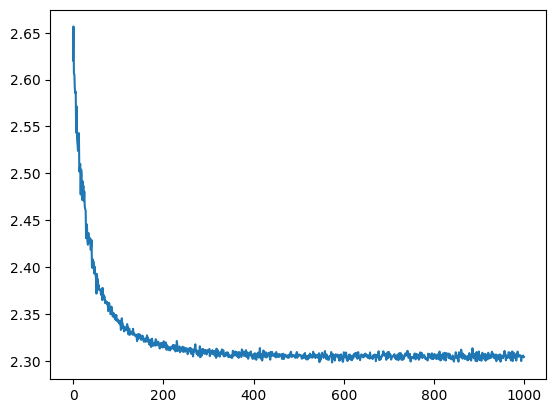

In [250]:
plt.plot(losses)

In [277]:
def greedy_decoding(model, src, context_size):
    cur_targ = torch.zeros((1,1)).type(torch.int)
    src_mask, _ = create_mask(src, src, 99)
    model.encode(src, src_mask)
    for i in range(context_size):
        src_mask, targ_mask = create_mask(src, cur_targ, 99)
        proj = model.decode(cur_targ, src_mask, targ_mask)
        tok = torch.argmax(proj[:,-1], keepdims=True)
        if tok.item() == 1:
            return cur_targ
        cur_targ = torch.cat([cur_targ, tok], dim=1)
    return cur_targ

src = torch.randint(2, 12, size=(1, 10))

cur_targ = greedy_decoding(model, src, 20)
print(src)
print(cur_targ)

tensor([[4, 8, 3, 9, 5, 3, 9, 7, 8, 9]])
tensor([[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])


# test training on real data

In [79]:
import torchtext.datasets
from torch.utils.data import DataLoader

train_data = torchtext.datasets.Multi30k(split='train', language_pair=('de', 'en'))
val_data = torchtext.datasets.Multi30k(split='valid', language_pair=('de', 'en'))

In [15]:
import en_core_web_sm
import de_core_news_sm

en_tokenizer = en_core_web_sm.load()
de_tokenizer = de_core_news_sm.load()

In [41]:
from collections import Counter

def get_unique_tokens(text, tokenizer):
    cnt = Counter()
    for doc in tokenizer.pipe(text):
        doc_tokens = [tok.text.strip() for tok in doc if len(tok.text) > 0]
        cnt.update(doc_tokens)
    return [tok[0] for tok in cnt.most_common(10000)]

src_text, targ_text = list(zip(*train_data))

de_toks = get_unique_tokens(src_text, de_tokenizer)
en_toks = get_unique_tokens(targ_text, en_tokenizer)


In [71]:
# special token indices
UNK_IDX = 0
PAD_IDX = 1
SOS_IDX = 2
EOS_IDX = 3

UNK = '<unk>' # Unknown
PAD = '<pad>' # Padding
SOS = '<sos>' # Start of sentence
EOS = '<eos>' # End of sentence

SPECIAL_TOKENS = [UNK, PAD, SOS, EOS]

class Vocab:
    def __init__(self, tokenizer, tokens):
        self.tokenizer = tokenizer
        self.tokens = SPECIAL_TOKENS + tokens
        self.token_idxs = {self.tokens[i]: i for i in range(len(tokens))}

    def __call__(self, text):
        return [self.numerify(tok.text.strip()) for tok in self.tokenizer(text)]
    
    def numerify(self, tok):
        if tok not in self.token_idxs:
            return UNK_IDX
        return self.token_idxs[tok]

de_vocab = Vocab(de_tokenizer, de_toks)
en_vocab = Vocab(en_tokenizer, en_toks)

In [121]:
from torch.nn.utils.rnn import pad_sequence

def make_dataloader(dataset, batch_size, context_size, device): 
    def collate_fn(batch):
        srcs = []
        targs = []
        for i, (src_sentence, targ_sentence) in enumerate(batch):
            src = de_vocab(src_sentence)
            targ = [SOS_IDX] + en_vocab(targ_sentence) + [EOS_IDX]
    
            srcs.append(torch.tensor(src))
            targs.append(torch.tensor(targ))
    
        src_batch = pad_sequence(srcs, padding_value=PAD_IDX, batch_first=True)
        targ_batch = pad_sequence(targs, padding_value=PAD_IDX, batch_first=True)
    
        # decoder wants target starting with SOS
        target_batch = targ_batch[:, :-1]
        # however when calculating loss we are only interested in tokens after SOS and ending with EOS
        label_batch = targ_batch[:, 1:]
        src_mask, targ_mask = create_mask(src_batch, target_batch, PAD_IDX) # TODO: understand what the hell happens with different context lengths
    
        all_batches = [src_batch, target_batch, label_batch, src_mask, targ_mask]
        return [b.to(device) for b in all_batches]

    return DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

train_dataloader = make_dataloader(train_data, 32, 40, "cpu")
val_dataloader = make_dataloader(val_data, 100, 40, "cpu")

In [185]:
from tqdm import tqdm

model = EncoderDecoderTransformer(
    n_heads=8, n_embed=128, dropout=0.2, n_blocks=6, context_size=44, input_vocab_size=len(de_vocab.tokens), output_vocab_size=len(en_vocab.tokens)
)

optim = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.98), eps=1e-9)

with tqdm(train_dataloader, unit="batch") as iter:
    losses = []
    for step, (src, targ, labels, src_mask, targ_mask) in enumerate(iter):
        # forward pass
        logits = model(src, targ, src_mask, targ_mask)
        loss = calculate_loss(logits, labels)
        losses.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()
        if step % 10 == 0:
            print(f"{loss.item()=}")
    
    

0batch [00:00, ?batch/s]/home/adam/dev/translate-gpt/.env/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
1batch [00:00,  2.06batch/s]

loss.item()=9.210733413696289


11batch [00:05,  2.13batch/s]

loss.item()=9.210649490356445


21batch [00:09,  2.19batch/s]

loss.item()=9.210260391235352


31batch [00:14,  2.23batch/s]

loss.item()=9.207955360412598


41batch [00:18,  2.17batch/s]

loss.item()=9.193553924560547


51batch [00:23,  2.10batch/s]

loss.item()=9.137707710266113


61batch [00:28,  2.18batch/s]

loss.item()=9.111954689025879


71batch [00:33,  2.13batch/s]

loss.item()=9.089198112487793


81batch [00:37,  2.18batch/s]

loss.item()=9.079070091247559


91batch [00:42,  2.15batch/s]

loss.item()=9.079970359802246


101batch [00:46,  2.12batch/s]

loss.item()=9.079747200012207


111batch [00:51,  2.18batch/s]

loss.item()=9.072866439819336


121batch [00:56,  2.20batch/s]

loss.item()=9.063436508178711


131batch [01:00,  2.15batch/s]

loss.item()=9.061756134033203


141batch [01:05,  2.23batch/s]

loss.item()=9.02640151977539


151batch [01:09,  2.23batch/s]

loss.item()=9.035606384277344


161batch [01:14,  2.20batch/s]

loss.item()=9.076016426086426


171batch [01:18,  2.14batch/s]

loss.item()=9.062559127807617


181batch [01:23,  2.12batch/s]

loss.item()=9.023770332336426


191batch [01:27,  2.26batch/s]

loss.item()=9.033185005187988


201batch [01:32,  2.14batch/s]

loss.item()=9.027458190917969


211batch [01:37,  2.05batch/s]

loss.item()=9.018912315368652


221batch [01:42,  1.92batch/s]

loss.item()=9.03642749786377


231batch [01:48,  1.76batch/s]

loss.item()=9.052026748657227


241batch [01:53,  1.85batch/s]

loss.item()=9.001538276672363


251batch [01:58,  1.89batch/s]

loss.item()=9.049471855163574


261batch [02:04,  1.85batch/s]

loss.item()=9.024253845214844


271batch [02:09,  1.94batch/s]

loss.item()=9.01122760772705


281batch [02:14,  1.84batch/s]

loss.item()=9.016337394714355


291batch [02:20,  1.82batch/s]

loss.item()=9.016438484191895


301batch [02:25,  1.87batch/s]

loss.item()=9.004523277282715


311batch [02:31,  1.92batch/s]

loss.item()=9.030062675476074


321batch [02:36,  1.89batch/s]

loss.item()=9.016047477722168


331batch [02:41,  1.84batch/s]

loss.item()=8.998820304870605


341batch [02:46,  1.87batch/s]

loss.item()=8.97903823852539


351batch [02:52,  1.87batch/s]

loss.item()=9.014290809631348


361batch [02:57,  1.99batch/s]

loss.item()=9.05443286895752


371batch [03:02,  1.90batch/s]

loss.item()=9.041675567626953


381batch [03:07,  2.02batch/s]

loss.item()=8.964580535888672


391batch [03:13,  1.79batch/s]

loss.item()=9.014985084533691


401batch [03:18,  1.90batch/s]

loss.item()=9.029491424560547


411batch [03:23,  1.87batch/s]

loss.item()=8.984395027160645


421batch [03:28,  1.87batch/s]

loss.item()=8.990285873413086


431batch [03:34,  1.88batch/s]

loss.item()=8.985082626342773


441batch [03:39,  1.97batch/s]

loss.item()=9.00655746459961


451batch [03:44,  1.83batch/s]

loss.item()=8.997050285339355


461batch [03:50,  1.91batch/s]

loss.item()=9.002702713012695


471batch [03:55,  1.93batch/s]

loss.item()=8.993941307067871


481batch [04:00,  1.86batch/s]

loss.item()=8.998924255371094


491batch [04:06,  1.87batch/s]

loss.item()=8.963919639587402


501batch [04:11,  1.86batch/s]

loss.item()=8.98376750946045


511batch [04:16,  1.86batch/s]

loss.item()=8.99299430847168


521batch [04:22,  1.74batch/s]

loss.item()=8.994638442993164


531batch [04:27,  1.88batch/s]

loss.item()=8.972437858581543


541batch [04:33,  1.70batch/s]

loss.item()=8.976280212402344


551batch [04:38,  1.83batch/s]

loss.item()=9.011720657348633


561batch [04:44,  1.78batch/s]

loss.item()=8.958436012268066


571batch [04:49,  1.82batch/s]

loss.item()=8.952786445617676


581batch [04:55,  1.86batch/s]

loss.item()=8.907593727111816


591batch [05:00,  1.82batch/s]

loss.item()=8.946897506713867


601batch [05:06,  1.89batch/s]

loss.item()=9.004509925842285


611batch [05:11,  1.80batch/s]

loss.item()=8.9861421585083


621batch [05:17,  1.79batch/s]

loss.item()=8.995495796203613


631batch [05:22,  1.73batch/s]

loss.item()=8.96332836151123


641batch [05:28,  1.87batch/s]

loss.item()=8.950708389282227


651batch [05:33,  1.86batch/s]

loss.item()=8.98873519897461


661batch [05:39,  1.86batch/s]

loss.item()=8.970311164855957


671batch [05:44,  1.80batch/s]

loss.item()=8.959149360656738


681batch [05:50,  1.86batch/s]

loss.item()=8.920761108398438


691batch [05:55,  1.76batch/s]

loss.item()=8.965910911560059


701batch [06:01,  1.80batch/s]

loss.item()=8.92894172668457


711batch [06:06,  1.86batch/s]

loss.item()=8.949209213256836


721batch [06:12,  1.81batch/s]

loss.item()=8.953653335571289


731batch [06:17,  1.83batch/s]

loss.item()=8.944999694824219


741batch [06:23,  1.74batch/s]

loss.item()=8.95530891418457


751batch [06:28,  1.72batch/s]

loss.item()=8.918329238891602


761batch [06:34,  1.75batch/s]

loss.item()=8.962823867797852


771batch [06:40,  1.72batch/s]

loss.item()=8.9678373336792


781batch [06:46,  1.82batch/s]

loss.item()=8.957608222961426


791batch [06:52,  1.72batch/s]

loss.item()=8.950309753417969


801batch [06:57,  1.73batch/s]

loss.item()=8.952887535095215


811batch [07:03,  1.77batch/s]

loss.item()=8.971698760986328


821batch [07:09,  1.77batch/s]

loss.item()=8.983675956726074


831batch [07:14,  1.85batch/s]

loss.item()=8.962743759155273


841batch [07:20,  1.76batch/s]

loss.item()=8.969167709350586


851batch [07:25,  1.76batch/s]

loss.item()=8.966465950012207


861batch [07:31,  1.82batch/s]

loss.item()=8.944661140441895


871batch [07:36,  1.71batch/s]

loss.item()=9.003609657287598


881batch [07:42,  1.72batch/s]

loss.item()=8.96571159362793


891batch [07:48,  1.77batch/s]

loss.item()=8.964508056640625


901batch [07:53,  1.81batch/s]

loss.item()=8.915078163146973


907batch [07:56,  1.90batch/s]


In [186]:
losses

[9.210733413696289,
 9.210726737976074,
 9.21072769165039,
 9.210715293884277,
 9.210716247558594,
 9.210707664489746,
 9.210700035095215,
 9.21069622039795,
 9.210679054260254,
 9.210673332214355,
 9.210649490356445,
 9.2106294631958,
 9.210603713989258,
 9.210601806640625,
 9.210576057434082,
 9.210556983947754,
 9.210526466369629,
 9.210470199584961,
 9.21037769317627,
 9.210357666015625,
 9.210260391235352,
 9.210247039794922,
 9.210076332092285,
 9.2099609375,
 9.209695816040039,
 9.209587097167969,
 9.209501266479492,
 9.20931625366211,
 9.208842277526855,
 9.208385467529297,
 9.207955360412598,
 9.207120895385742,
 9.206398963928223,
 9.205703735351562,
 9.204448699951172,
 9.20336627960205,
 9.202404975891113,
 9.199590682983398,
 9.197884559631348,
 9.194610595703125,
 9.193553924560547,
 9.187616348266602,
 9.184483528137207,
 9.179563522338867,
 9.174766540527344,
 9.166749954223633,
 9.159613609313965,
 9.157155990600586,
 9.145181655883789,
 9.141651153564453,
 9.137707710

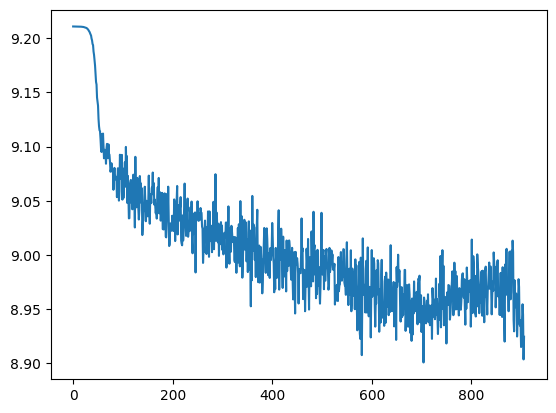

In [191]:
import matplotlib.pyplot as plt

plt.plot(losses)